## Color Distribution Data

[INFO] Loading real...


  └─ real: 100%|███████████████████████| 10000/10000 [00:04<00:00, 2174.10img/s]


  └─ Loaded 10000 features for 'real'

[INFO] Loading gan...


  └─ gan: 100%|████████████████████████| 10000/10000 [00:04<00:00, 2036.77img/s]


  └─ Loaded 10000 features for 'gan'

[INFO] Loading diffusion...


  └─ diffusion: 100%|██████████████████| 10000/10000 [00:04<00:00, 2015.21img/s]


  └─ Loaded 10000 features for 'diffusion'



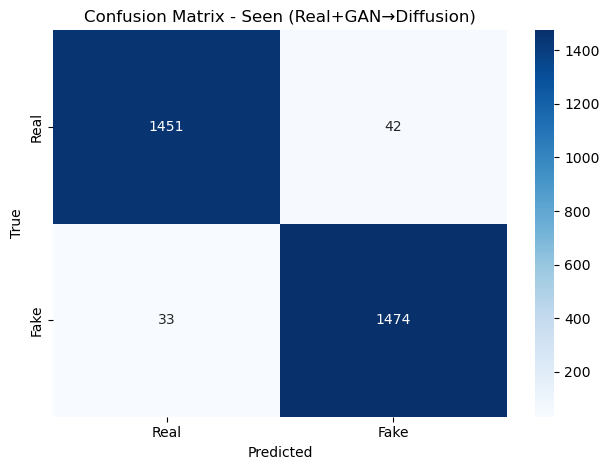

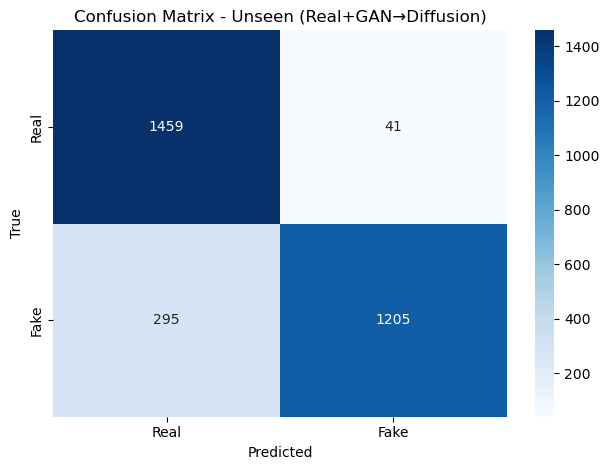

Unseen Accuracy per label (Real+GAN→Diffusion): Real=0.9727, Fake=0.8033


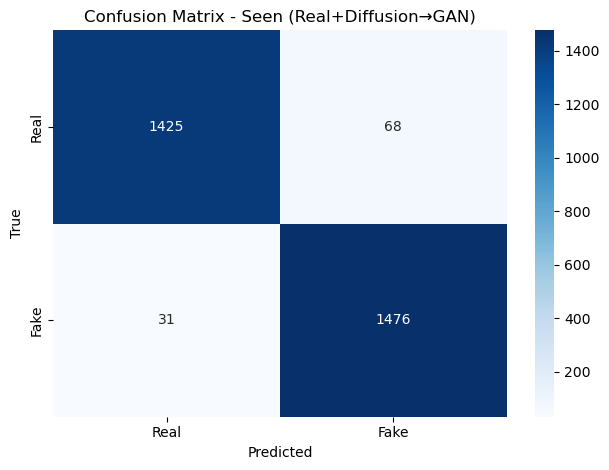

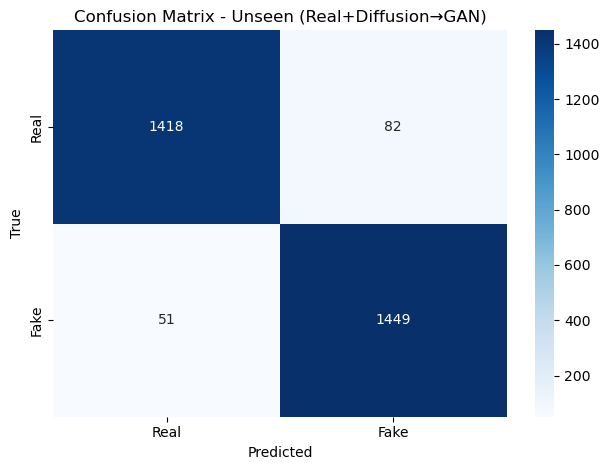

Unseen Accuracy per label (Real+Diffusion→GAN): Real=0.9453, Fake=0.9660

=== Generalization Results (ImageNet dataset: Color Distribution Data) ===
       Training Setup    Test on  Accuracy (Seen)  Accuracy (Unseen)  G-Score  \
0            Real+GAN  Diffusion           0.9750             0.8880   0.9108   
1      Real+Diffusion        GAN           0.9670             0.9557   0.9883   
2  Real+GAN+Diffusion    Holdout           0.9813             0.9827   1.0014   

   Unseen Real Acc  Unseen Fake Acc  
0           0.9727           0.8033  
1           0.9453           0.9660  
2           0.9767           0.9887  


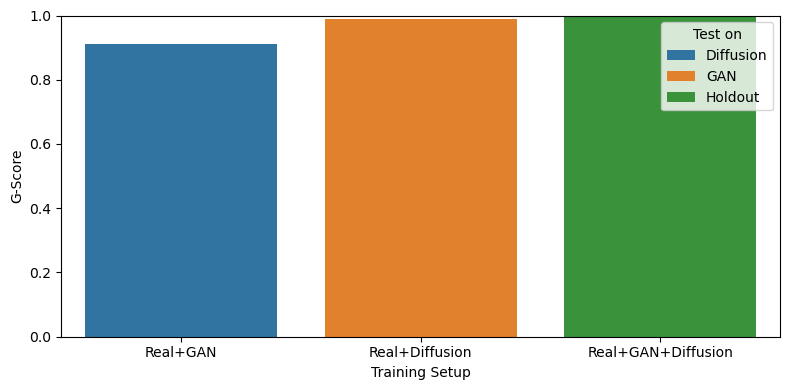

In [10]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix


# ------------------ DATASETS ------------------

DATASETS = {
    'bedroom': {
        'real': "../data/BEST/bedroom/real_200x200",
        'gan': "../data/BEST/bedroom/gansformer",
        'diffusion': "../data/BEST/bedroom/ddpm"
    },
    'face': {
        'real': '../data/BEST/face/real',
        'gan': '../data/BEST/face/stylegan2',
        'diffusion': '../data/BEST/face/palette'
    },
    'imagenet': {
        'real': '../data/BEST/imagenet/real_imagenet',
        'gan': '../data/BEST/imagenet/big_gan',
        'diffusion': '../data/BEST/imagenet/vq_diffusion'
    }
}

# ------------------ FEATURE EXTRACTION ------------------

def extract_color_features(image_path, bins=(16, 16, 16)):
    image = cv2.imread(image_path)
    if image is None:
        return None
    try:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        image_ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

        hist_rgb = cv2.calcHist([image_rgb], [0, 1, 2], None, bins, [0, 256]*3).flatten()
        hist_hsv = cv2.calcHist([image_hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256]).flatten()
        hist_ycrcb = cv2.calcHist([image_ycrcb], [1, 2], None, (16, 16), [0, 256, 0, 256]).flatten()

        return np.concatenate([hist_rgb, hist_hsv, hist_ycrcb])
    except:
        return None

def load_color_features_by_class(dataset_dict):
    data = {'real': [], 'gan': [], 'diffusion': []}
    for label, root_folder in dataset_dict.items():
        print(f"[INFO] Loading {label}...")
        
        # 1) Gather all image paths under every subfolder
        image_paths = []
        for dirpath, _, filenames in os.walk(root_folder):
            for fname in filenames:
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(dirpath, fname))
        
        # 2) Iterate with tqdm for a percentage bar
        for img_path in tqdm(
                image_paths,
                desc=f"  └─ {label}",
                unit="img",
                ncols=80
            ):
            feat = extract_color_features(img_path)
            if feat is not None:
                data[label].append(feat)
        
        print(f"  └─ Loaded {len(data[label])} features for '{label}'\n")
    return data

# ---------------- GENERALIZATION EXPERIMENT ----------------

def run_generalization_experiment(data, train_labels, test_label, title_suffix=''):
    # Split real class
    real_data = data['real']
    train_real_all, unseen_real = train_test_split(real_data, test_size=0.15, random_state=42)

    # Other class
    other_class = [lbl for lbl in train_labels if lbl != 'real'][0]
    train_other_all, _ = train_test_split(data[other_class], test_size=0.15, random_state=42)

    # Undersample to equal size
    n_train = min(len(train_real_all), len(train_other_all))
    train_real  = train_real_all[:n_train]
    train_other = train_other_all[:n_train]

    X_train_full = train_real + train_other
    y_train_full = [0]*n_train + [1]*n_train

    # Validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full,
        stratify=y_train_full, test_size=0.3, random_state=42
    )

    # Balance training set
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)

    # Build unseen test set
    _, unseen_fake = train_test_split(data[test_label], test_size=0.15, random_state=42)
    n_unseen = min(len(unseen_real), len(unseen_fake), len(y_val))
    X_test = unseen_real[:n_unseen] + unseen_fake[:n_unseen]
    y_test = [0]*n_unseen + [1]*n_unseen

    # Train classifier
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    # Predictions
    y_val_pred  = clf.predict(X_val[:2*n_unseen])
    y_test_pred = clf.predict(X_test)

    acc_seen   = accuracy_score(y_val[:2*n_unseen], y_val_pred)
    acc_unseen = accuracy_score(y_test, y_test_pred)
    g_score    = 1 - ((acc_seen - acc_unseen) / (acc_seen + 1e-8))

    # Plot confusion matrices
    def plot_cm(y_true, y_pred, title):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
        plt.title(title)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    plot_cm(y_val[:2*n_unseen], y_val_pred,  f"Confusion Matrix - Seen ({title_suffix})")
    plot_cm(y_test,           y_test_pred, f"Confusion Matrix - Unseen ({title_suffix})")

    # Per‐label unseen accuracy
    cm_u = confusion_matrix(y_test, y_test_pred)
    acc_real_unseen = cm_u[0,0]/cm_u[0].sum() if cm_u[0].sum()>0 else 0.0
    acc_fake_unseen = cm_u[1,1]/cm_u[1].sum() if cm_u[1].sum()>0 else 0.0

    print(f"Unseen Accuracy per label ({title_suffix}): "
          f"Real={acc_real_unseen:.4f}, Fake={acc_fake_unseen:.4f}")

    return (
        round(acc_seen, 4),
        round(acc_unseen, 4),
        round(g_score,    4),
        round(acc_real_unseen, 4),
        round(acc_fake_unseen, 4)
    )

# ---------------- PIPELINE RUNNER ----------------
def run_generalization_pipeline(dataset_name='imagenet'):
    data    = load_color_features_by_class(DATASETS[dataset_name])
    results = []

    # 1) Real + GAN → Diffusion
    s, u, g, r_acc, f_acc = run_generalization_experiment(
        data, ['real','gan'], 'diffusion', title_suffix='Real+GAN→Diffusion'
    )
    results.append(['Real+GAN', 'Diffusion', s, u, g, r_acc, f_acc])

    # 2) Real + Diffusion → GAN
    s, u, g, r_acc, f_acc = run_generalization_experiment(
        data, ['real','diffusion'], 'gan', title_suffix='Real+Diffusion→GAN'
    )
    results.append(['Real+Diffusion', 'GAN', s, u, g, r_acc, f_acc])

    # 3) Holdout with all three
    X_all = data['real'] + data['gan'] + data['diffusion']
    y_all = [0]*len(data['real']) + [1]*len(data['gan']) + [1]*len(data['diffusion'])
    X_bal, y_bal = SMOTE(random_state=42).fit_resample(X_all, y_all)

    X_temp, X_test, y_temp, y_test = train_test_split(
        X_bal, y_bal, test_size=0.15, stratify=y_bal, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
    )

    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    seen_acc   = accuracy_score(y_val,     clf.predict(X_val))
    unseen_acc = accuracy_score(y_test,    clf.predict(X_test))
    g_score    = 1 - ((seen_acc - unseen_acc) / (seen_acc + 1e-8))

    cm_h = confusion_matrix(y_test, clf.predict(X_test))
    real_acc = cm_h[0,0]/cm_h[0].sum()
    fake_acc = cm_h[1,1]/cm_h[1].sum()

    results.append([
        'Real+GAN+Diffusion', 'Holdout',
        round(seen_acc,4), round(unseen_acc,4), round(g_score,4),
        round(real_acc,4), round(fake_acc,4)
    ])

    df = pd.DataFrame(
        results,
        columns=[
            "Training Setup","Test on",
            "Accuracy (Seen)","Accuracy (Unseen)","G-Score",
            "Unseen Real Acc","Unseen Fake Acc"
        ]
    )
    print("\n=== Generalization Results (ImageNet dataset: Color Distribution Data) ===")
    print(df)
    return df

# ---------------- USAGE ----------------
if __name__ == "__main__":
    df = run_generalization_pipeline(dataset_name='imagenet')
    plt.figure(figsize=(8,4))
    sns.barplot(data=df, x="Training Setup", y="G-Score", hue="Test on")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

## Noise Pattern Data

[INFO] Loading real images...


  └─ real: 100%|████████████████████████| 10000/10000 [01:01<00:00, 163.64img/s]


  └─ Loaded 10000 features for 'real'

[INFO] Loading gan images...


  └─ gan: 100%|█████████████████████████| 10000/10000 [01:02<00:00, 159.40img/s]


  └─ Loaded 10000 features for 'gan'

[INFO] Loading diffusion images...


  └─ diffusion: 100%|███████████████████| 10000/10000 [01:04<00:00, 156.10img/s]


  └─ Loaded 10000 features for 'diffusion'



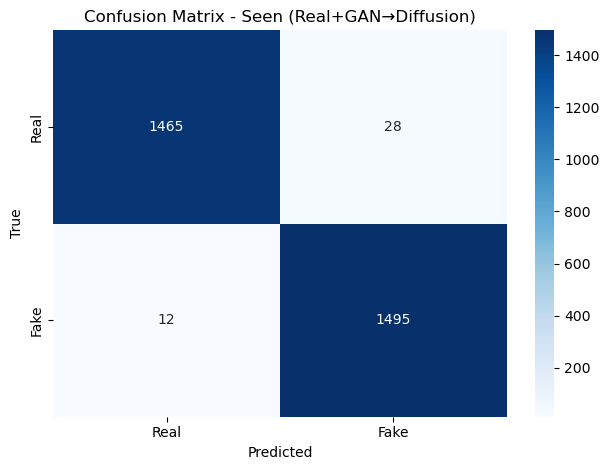

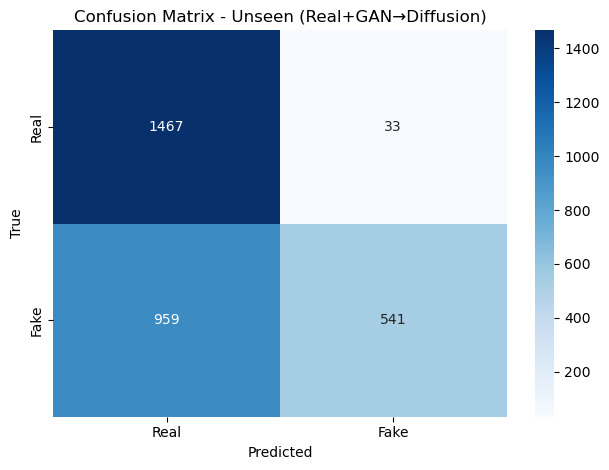

Unseen Accuracy per label (Real+GAN→Diffusion): Real=0.9780, Fake=0.3607


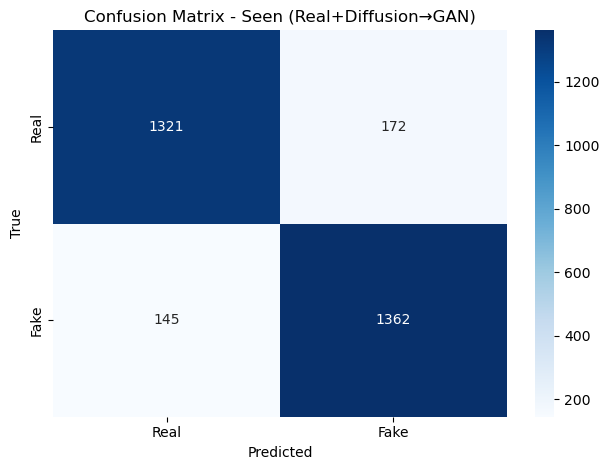

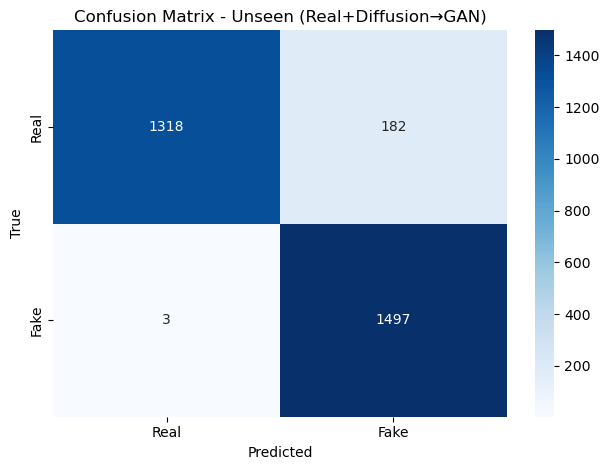

Unseen Accuracy per label (Real+Diffusion→GAN): Real=0.8787, Fake=0.9980

=== Generalization Results (ImageNet dataset: Noise Features Data) ===
       Training Setup    Test on  Accuracy (Seen)  Accuracy (Unseen)  G-Score  \
0            Real+GAN  Diffusion           0.9867             0.6693   0.6784   
1      Real+Diffusion        GAN           0.8943             0.9383   1.0492   
2  Real+GAN+Diffusion    Holdout           0.9465             0.9445   0.9979   

   Unseen Real Acc  Unseen Fake Acc  
0           0.9780           0.3607  
1           0.8787           0.9980  
2           0.9523           0.9367  


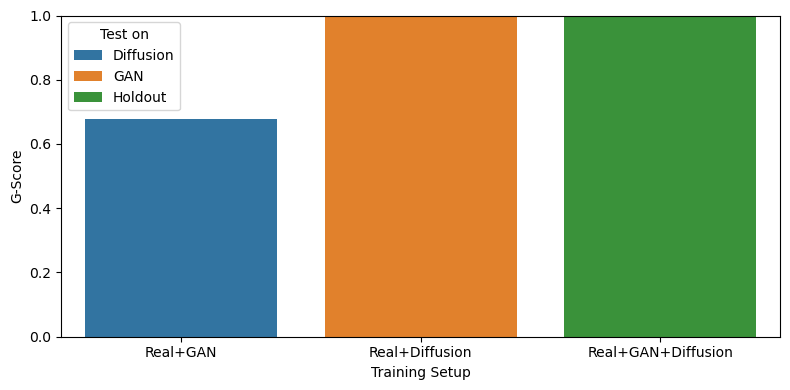

In [11]:
import os
import cv2
import numpy as np
import pywt
from glob import glob
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage.util import view_as_windows
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix

# ---------------- DATASET PATHS ----------------

DATASETS = {
    'bedroom': {
        'real': "../data/BEST/bedroom/real_200x200",
        'gan': "../data/BEST/bedroom/gansformer",
        'diffusion': "../data/BEST/bedroom/ddpm"
    },
    'face': {
        'real': "../data/BEST/face/real",
        'gan': "../data/BEST/face/stylegan2",
        'diffusion': "../data/BEST/face/palette"
    },
    'imagenet': {
        'real': '../data/BEST/imagenet/real_imagenet',
        'gan': '../data/BEST/imagenet/big_gan',
        'diffusion': '../data/BEST/imagenet/vq_diffusion'
    }
}

# ---------------- FEATURE EXTRACTION ----------------

def estimate_local_noise(image, window_size=7):
    padded_img = np.pad(image, pad_width=window_size // 2, mode='reflect')
    windows = view_as_windows(padded_img, (window_size, window_size))
    return np.std(windows, axis=(2, 3))

def extract_wavelet_noise(image, wavelet='db1', level=1):
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)
    _, (cH, cV, cD) = coeffs
    return np.sqrt(cH**2 + cV**2 + cD**2)

def extract_combined_noise_features(image_path, window_size=7, wavelet='db1'):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = img.astype(np.float32) / 255.0
    try:
        local = estimate_local_noise(img, window_size)
        wavelet_energy = extract_wavelet_noise(img, wavelet)
        hist_local = np.histogram(local.flatten(), bins=64, range=(0, 1), density=True)[0]
        hist_wavelet = np.histogram(wavelet_energy.flatten(), bins=64, range=(0, 1), density=True)[0]
        return np.concatenate([hist_local, hist_wavelet])
    except:
        return None

def load_noise_features_by_class(dataset_dict, method='combined'):
    data = {'real': [], 'gan': [], 'diffusion': []}
    for label, root_folder in dataset_dict.items():
        print(f"[INFO] Loading {label} images...")
        image_paths = []
        for dirpath, _, filenames in os.walk(root_folder):
            for fname in filenames:
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(dirpath, fname))
        for img_path in tqdm(
                image_paths,
                desc=f"  └─ {label}",
                unit="img",
                ncols=80
            ):
            if method == 'combined':
                feat = extract_combined_noise_features(img_path)
            else:
                feat = extract_noise_features(img_path)
            if feat is not None:
                data[label].append(feat)
        print(f"  └─ Loaded {len(data[label])} features for '{label}'\n")

    return data

# ---------------- GENERALIZATION EXPERIMENT ----------------

def run_generalization_experiment(data, train_labels, test_label, title_suffix=''):
    # Split real class
    real_data = data['real']
    train_real_all, unseen_real = train_test_split(real_data, test_size=0.15, random_state=42)

    # Other class
    other_class = [lbl for lbl in train_labels if lbl != 'real'][0]
    train_other_all, _ = train_test_split(data[other_class], test_size=0.15, random_state=42)

    # Undersample to equal size
    n_train = min(len(train_real_all), len(train_other_all))
    train_real  = train_real_all[:n_train]
    train_other = train_other_all[:n_train]

    X_train_full = train_real + train_other
    y_train_full = [0]*n_train + [1]*n_train

    # Validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full,
        stratify=y_train_full, test_size=0.3, random_state=42
    )

    # Balance training set
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)

    # Build unseen test set
    _, unseen_fake = train_test_split(data[test_label], test_size=0.15, random_state=42)
    n_unseen = min(len(unseen_real), len(unseen_fake), len(y_val))
    X_test = unseen_real[:n_unseen] + unseen_fake[:n_unseen]
    y_test = [0]*n_unseen + [1]*n_unseen

    # Train classifier
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    # Predictions
    y_val_pred  = clf.predict(X_val[:2*n_unseen])
    y_test_pred = clf.predict(X_test)

    acc_seen   = accuracy_score(y_val[:2*n_unseen], y_val_pred)
    acc_unseen = accuracy_score(y_test, y_test_pred)
    g_score    = 1 - ((acc_seen - acc_unseen) / (acc_seen + 1e-8))

    # Plot confusion matrices
    def plot_cm(y_true, y_pred, title):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
        plt.title(title)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    plot_cm(y_val[:2*n_unseen], y_val_pred,  f"Confusion Matrix - Seen ({title_suffix})")
    plot_cm(y_test,           y_test_pred, f"Confusion Matrix - Unseen ({title_suffix})")

    # Per‐label unseen accuracy
    cm_u = confusion_matrix(y_test, y_test_pred)
    acc_real_unseen = cm_u[0,0]/cm_u[0].sum() if cm_u[0].sum()>0 else 0.0
    acc_fake_unseen = cm_u[1,1]/cm_u[1].sum() if cm_u[1].sum()>0 else 0.0

    print(f"Unseen Accuracy per label ({title_suffix}): "
          f"Real={acc_real_unseen:.4f}, Fake={acc_fake_unseen:.4f}")

    return (
        round(acc_seen, 4),
        round(acc_unseen, 4),
        round(g_score,    4),
        round(acc_real_unseen, 4),
        round(acc_fake_unseen, 4)
    )

# ---------------- PIPELINE RUNNER ----------------
def run_generalization_pipeline(dataset_name='imagenet'):
    data    = load_noise_features_by_class(DATASETS[dataset_name])
    results = []

    # 1) Real + GAN → Diffusion
    s, u, g, r_acc, f_acc = run_generalization_experiment(
        data, ['real','gan'], 'diffusion', title_suffix='Real+GAN→Diffusion'
    )
    results.append(['Real+GAN', 'Diffusion', s, u, g, r_acc, f_acc])

    # 2) Real + Diffusion → GAN
    s, u, g, r_acc, f_acc = run_generalization_experiment(
        data, ['real','diffusion'], 'gan', title_suffix='Real+Diffusion→GAN'
    )
    results.append(['Real+Diffusion', 'GAN', s, u, g, r_acc, f_acc])

    # 3) Holdout with all three
    X_all = data['real'] + data['gan'] + data['diffusion']
    y_all = [0]*len(data['real']) + [1]*len(data['gan']) + [1]*len(data['diffusion'])
    X_bal, y_bal = SMOTE(random_state=42).fit_resample(X_all, y_all)

    X_temp, X_test, y_temp, y_test = train_test_split(
        X_bal, y_bal, test_size=0.15, stratify=y_bal, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
    )

    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    seen_acc   = accuracy_score(y_val,     clf.predict(X_val))
    unseen_acc = accuracy_score(y_test,    clf.predict(X_test))
    g_score    = 1 - ((seen_acc - unseen_acc) / (seen_acc + 1e-8))

    cm_h = confusion_matrix(y_test, clf.predict(X_test))
    real_acc = cm_h[0,0]/cm_h[0].sum()
    fake_acc = cm_h[1,1]/cm_h[1].sum()

    results.append([
        'Real+GAN+Diffusion', 'Holdout',
        round(seen_acc,4), round(unseen_acc,4), round(g_score,4),
        round(real_acc,4), round(fake_acc,4)
    ])

    df = pd.DataFrame(
        results,
        columns=[
            "Training Setup","Test on",
            "Accuracy (Seen)","Accuracy (Unseen)","G-Score",
            "Unseen Real Acc","Unseen Fake Acc"
        ]
    )
    print("\n=== Generalization Results (ImageNet dataset: Noise Features Data) ===")
    print(df)
    return df

# ---------------- USAGE ----------------
if __name__ == "__main__":
    df = run_generalization_pipeline(dataset_name='imagenet')
    plt.figure(figsize=(8,4))
    sns.barplot(data=df, x="Training Setup", y="G-Score", hue="Test on")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

## Frequency Domain Data

[INFO] Extracting FFT from real...


  └─ real: 100%|███████████████████████| 10000/10000 [00:09<00:00, 1016.38img/s]


  └─ Loaded 10000 features for 'real'

[INFO] Extracting FFT from gan...


  └─ gan: 100%|█████████████████████████| 10000/10000 [00:10<00:00, 962.89img/s]


  └─ Loaded 10000 features for 'gan'

[INFO] Extracting FFT from diffusion...


  └─ diffusion: 100%|███████████████████| 10000/10000 [00:10<00:00, 984.26img/s]


  └─ Loaded 9999 features for 'diffusion'



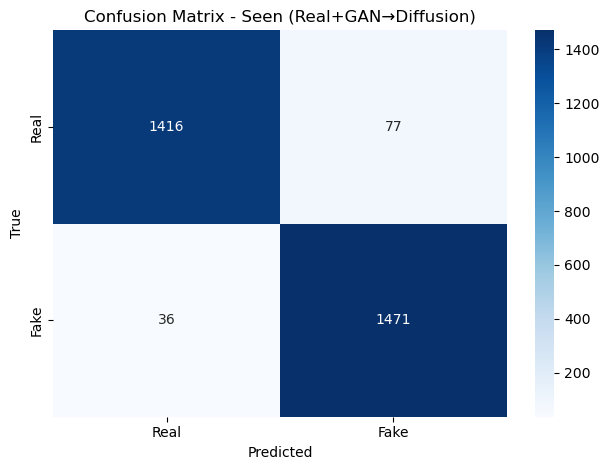

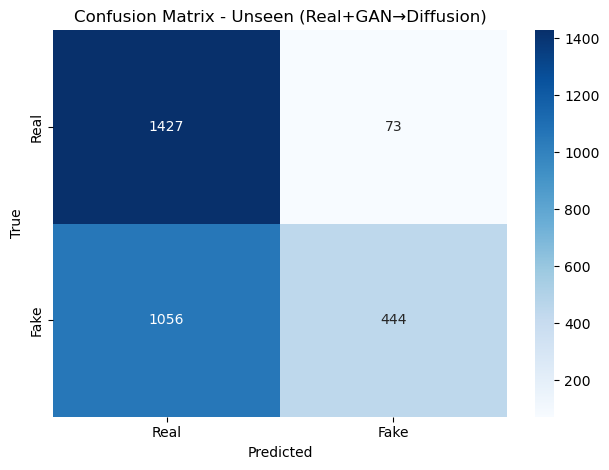

Unseen Accuracy per label (Real+GAN→Diffusion): Real=0.9513, Fake=0.2960


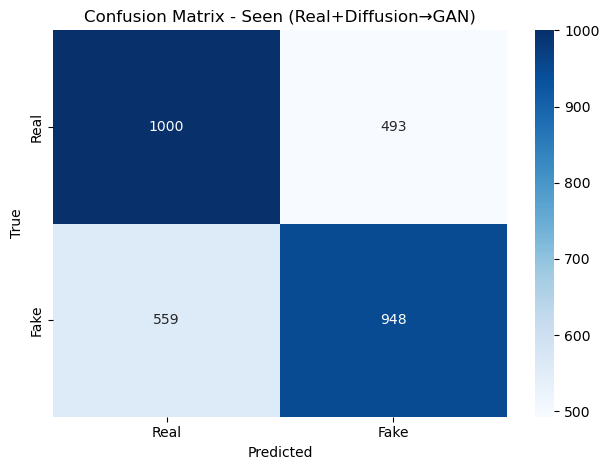

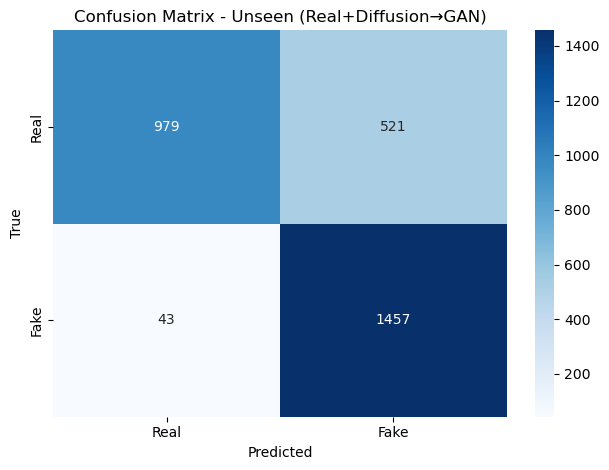

Unseen Accuracy per label (Real+Diffusion→GAN): Real=0.6527, Fake=0.9713

=== Generalization Results (ImageNet dataset: Frequency Domain Data) ===
       Training Setup    Test on  Accuracy (Seen)  Accuracy (Unseen)  G-Score  \
0            Real+GAN  Diffusion           0.9623             0.6237   0.6481   
1      Real+Diffusion        GAN           0.6493             0.8120   1.2505   
2  Real+GAN+Diffusion    Holdout           0.8007             0.8087   1.0099   

   Unseen Real Acc  Unseen Fake Acc  
0           0.9513           0.2960  
1           0.6527           0.9713  
2           0.8693           0.7480  


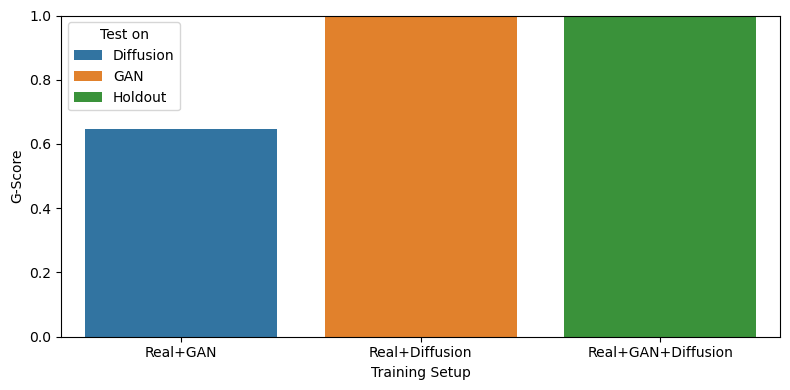

In [12]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from scipy.stats import linregress
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter


# ---------------- DATASET ----------------

DATASETS = {
    'bedroom': {
        'real': "../data/BEST/bedroom/real_200x200",
        'gan': "../data/BEST/bedroom/gansformer",
        'diffusion': "../data/BEST/bedroom/ddpm"
    },
    'face': {
        'real': "../data/BEST/face/real",
        'gan': "../data/BEST/face/stylegan2",
        'diffusion': "../data/BEST/face/palette"
    },
    'imagenet': {
        'real': "../data/BEST/imagenet/real_imagenet",
        'gan': "../data/BEST/imagenet/big_gan",
        'diffusion': "../data/BEST/imagenet/vq_diffusion"
    }
}

# ---------------- FEATURE EXTRACTION ----------------

def compute_fft_features(image, return_profile=False):
    H, W = image.shape
    if np.std(image) < 1e-6:
        return (np.nan, np.nan, None) if return_profile else (np.nan, np.nan)

    f_transform = np.fft.fft2(image)
    f_shifted = np.fft.fftshift(f_transform)
    log_magnitude = np.log1p(np.abs(f_shifted))

    y, x = np.indices((H, W))
    center = np.array([H // 2, W // 2])
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2).astype(np.int32)

    radial_sum = np.bincount(r.ravel(), weights=log_magnitude.ravel())
    radial_count = np.bincount(r.ravel())
    radial_profile = radial_sum / (radial_count + 1e-8)

    freqs = np.arange(1, len(radial_profile))
    power = radial_profile[1:]
    mask = power > 0

    if np.sum(mask) < 10:
        return (np.nan, np.nan, radial_profile) if return_profile else (np.nan, np.nan)

    log_freqs = np.log(freqs[mask])
    log_power = np.log(power[mask])
    if np.any(np.isnan(log_power)) or np.any(np.isinf(log_power)):
        return (np.nan, np.nan, radial_profile) if return_profile else (np.nan, np.nan)

    slope, _, _, _, _ = linregress(log_freqs, log_power)
    cutoff = int(0.33 * len(power))
    hf_ratio = np.sum(power[cutoff:]) / (np.sum(power) + 1e-8)
    return (-slope, hf_ratio, radial_profile) if return_profile else (-slope, hf_ratio)

import os
from glob import glob
from tqdm import tqdm
import cv2
import numpy as np

def load_fft_features_by_class(dataset_dict):
    data = {'real': [], 'gan': [], 'diffusion': []}
    for label, root_folder in dataset_dict.items():
        print(f"[INFO] Extracting FFT from {label}...")
        image_paths = []
        for dirpath, _, filenames in os.walk(root_folder):
            for fname in filenames:
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(dirpath, fname))
        for file_path in tqdm(
                image_paths,
                desc=f"  └─ {label}",
                unit="img",
                ncols=80
            ):
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = img.astype(np.float32) / 255.0
            slope, hf_ratio, _ = compute_fft_features(img, return_profile=True)
            if not np.isnan(slope) and not np.isnan(hf_ratio):
                data[label].append([slope, hf_ratio])

        print(f"  └─ Loaded {len(data[label])} features for '{label}'\n")

    return data

# ---------------- UTILS ----------------

def compute_per_class_accuracies(y_true, y_pred):
    labels = np.unique(y_true)
    accs = {}
    for label in labels:
        mask = np.array(y_true) == label
        accs[f"Acc Label {label}"] = round(accuracy_score(np.array(y_true)[mask], np.array(y_pred)[mask]), 4)
    return accs

# ---------------- GENERALIZATION EXPERIMENT ----------------

def run_generalization_experiment(data, train_labels, test_label, title_suffix=''):
    # Split real class
    real_data = data['real']
    train_real_all, unseen_real = train_test_split(real_data, test_size=0.15, random_state=42)

    # Other class
    other_class = [lbl for lbl in train_labels if lbl != 'real'][0]
    train_other_all, _ = train_test_split(data[other_class], test_size=0.15, random_state=42)

    # Undersample to equal size
    n_train = min(len(train_real_all), len(train_other_all))
    train_real  = train_real_all[:n_train]
    train_other = train_other_all[:n_train]

    X_train_full = train_real + train_other
    y_train_full = [0]*n_train + [1]*n_train

    # Validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full,
        stratify=y_train_full, test_size=0.3, random_state=42
    )

    # Balance training set
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)

    # Build unseen test set
    _, unseen_fake = train_test_split(data[test_label], test_size=0.15, random_state=42)
    n_unseen = min(len(unseen_real), len(unseen_fake), len(y_val))
    X_test = unseen_real[:n_unseen] + unseen_fake[:n_unseen]
    y_test = [0]*n_unseen + [1]*n_unseen

    # Train classifier
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    # Predictions
    y_val_pred  = clf.predict(X_val[:2*n_unseen])
    y_test_pred = clf.predict(X_test)

    acc_seen   = accuracy_score(y_val[:2*n_unseen], y_val_pred)
    acc_unseen = accuracy_score(y_test, y_test_pred)
    g_score    = 1 - ((acc_seen - acc_unseen) / (acc_seen + 1e-8))

    # Plot confusion matrices
    def plot_cm(y_true, y_pred, title):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
        plt.title(title)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    plot_cm(y_val[:2*n_unseen], y_val_pred,  f"Confusion Matrix - Seen ({title_suffix})")
    plot_cm(y_test,           y_test_pred, f"Confusion Matrix - Unseen ({title_suffix})")

    # Per‐label unseen accuracy
    cm_u = confusion_matrix(y_test, y_test_pred)
    acc_real_unseen = cm_u[0,0]/cm_u[0].sum() if cm_u[0].sum()>0 else 0.0
    acc_fake_unseen = cm_u[1,1]/cm_u[1].sum() if cm_u[1].sum()>0 else 0.0

    print(f"Unseen Accuracy per label ({title_suffix}): "
          f"Real={acc_real_unseen:.4f}, Fake={acc_fake_unseen:.4f}")

    return (
        round(acc_seen, 4),
        round(acc_unseen, 4),
        round(g_score,    4),
        round(acc_real_unseen, 4),
        round(acc_fake_unseen, 4)
    )

# ---------------- PIPELINE RUNNER ----------------
def run_generalization_pipeline(dataset_name='imagenet'):
    data    = load_fft_features_by_class(DATASETS[dataset_name])
    results = []

    # 1) Real + GAN → Diffusion
    s, u, g, r_acc, f_acc = run_generalization_experiment(
        data, ['real','gan'], 'diffusion', title_suffix='Real+GAN→Diffusion'
    )
    results.append(['Real+GAN', 'Diffusion', s, u, g, r_acc, f_acc])

    # 2) Real + Diffusion → GAN
    s, u, g, r_acc, f_acc = run_generalization_experiment(
        data, ['real','diffusion'], 'gan', title_suffix='Real+Diffusion→GAN'
    )
    results.append(['Real+Diffusion', 'GAN', s, u, g, r_acc, f_acc])

    # 3) Holdout with all three
    X_all = data['real'] + data['gan'] + data['diffusion']
    y_all = [0]*len(data['real']) + [1]*len(data['gan']) + [1]*len(data['diffusion'])
    X_bal, y_bal = SMOTE(random_state=42).fit_resample(X_all, y_all)

    X_temp, X_test, y_temp, y_test = train_test_split(
        X_bal, y_bal, test_size=0.15, stratify=y_bal, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
    )

    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    seen_acc   = accuracy_score(y_val,     clf.predict(X_val))
    unseen_acc = accuracy_score(y_test,    clf.predict(X_test))
    g_score    = 1 - ((seen_acc - unseen_acc) / (seen_acc + 1e-8))

    cm_h = confusion_matrix(y_test, clf.predict(X_test))
    real_acc = cm_h[0,0]/cm_h[0].sum()
    fake_acc = cm_h[1,1]/cm_h[1].sum()

    results.append([
        'Real+GAN+Diffusion', 'Holdout',
        round(seen_acc,4), round(unseen_acc,4), round(g_score,4),
        round(real_acc,4), round(fake_acc,4)
    ])

    df = pd.DataFrame(
        results,
        columns=[
            "Training Setup","Test on",
            "Accuracy (Seen)","Accuracy (Unseen)","G-Score",
            "Unseen Real Acc","Unseen Fake Acc"
        ]
    )
    print("\n=== Generalization Results (ImageNet dataset: Frequency Domain Data) ===")
    print(df)
    return df

# ---------------- USAGE ----------------
if __name__ == "__main__":
    df = run_generalization_pipeline(dataset_name='imagenet')
    plt.figure(figsize=(8,4))
    sns.barplot(data=df, x="Training Setup", y="G-Score", hue="Test on")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

## Texture & Structure Data

[INFO] Extracting real features...


  └─ real: 100%|█████████████████████████| 10000/10000 [03:46<00:00, 44.13img/s]


  └─ Loaded 10000 features for 'real'

[INFO] Extracting gan features...


  └─ gan: 100%|██████████████████████████| 10000/10000 [03:50<00:00, 43.43img/s]


  └─ Loaded 10000 features for 'gan'

[INFO] Extracting diffusion features...


  └─ diffusion: 100%|████████████████████| 10000/10000 [03:50<00:00, 43.39img/s]


  └─ Loaded 10000 features for 'diffusion'



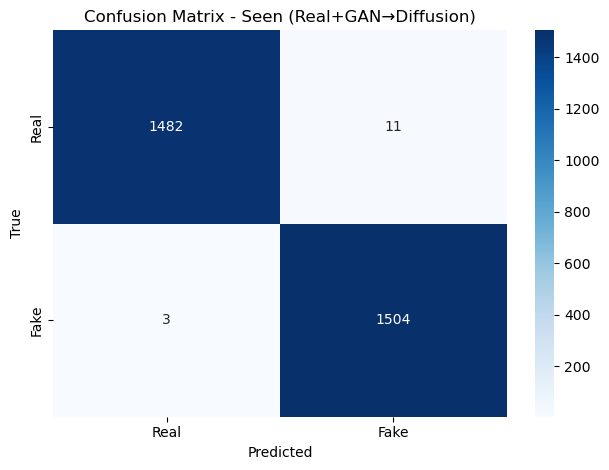

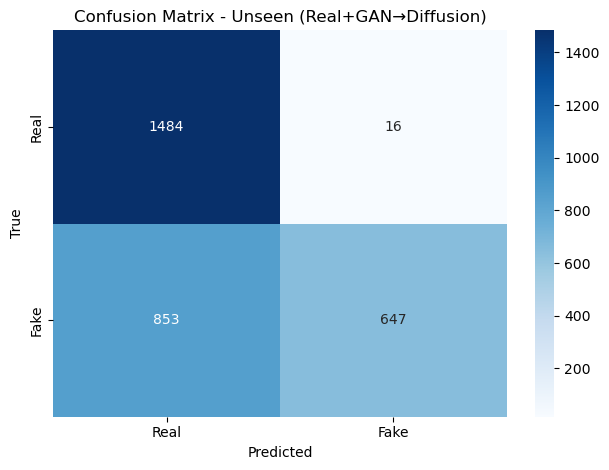

Unseen Accuracy per label (Real+GAN→Diffusion): Real=0.9893, Fake=0.4313


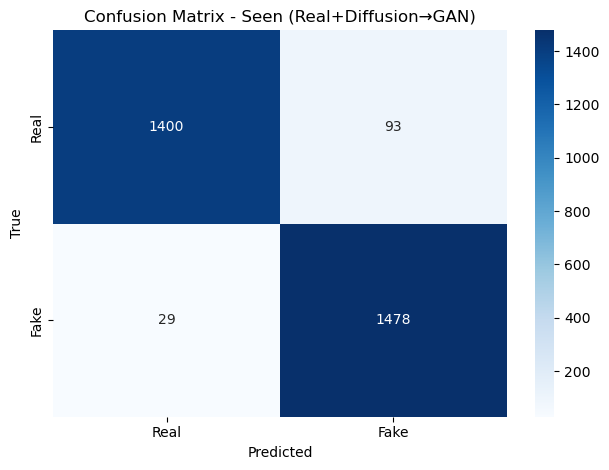

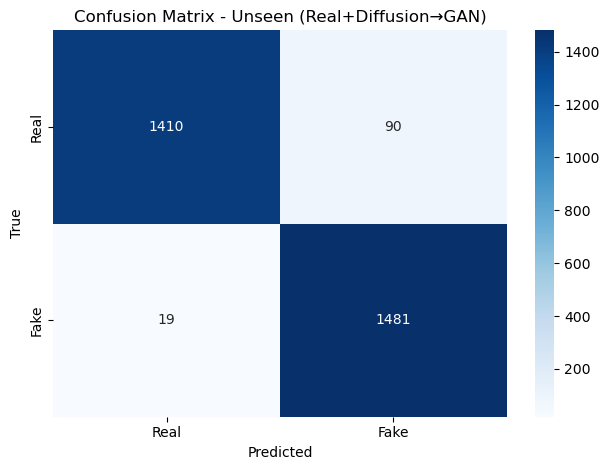

Unseen Accuracy per label (Real+Diffusion→GAN): Real=0.9400, Fake=0.9873

=== Generalization Results (ImageNet dataset: Texture & Structure Data) ===
       Training Setup    Test on  Accuracy (Seen)  Accuracy (Unseen)  G-Score  \
0            Real+GAN  Diffusion           0.9953             0.7103   0.7137   
1      Real+Diffusion        GAN           0.9593             0.9637   1.0045   
2  Real+GAN+Diffusion    Holdout           0.9795             0.9818   1.0024   

   Unseen Real Acc  Unseen Fake Acc  
0           0.9893           0.4313  
1           0.9400           0.9873  
2           0.9733           0.9903  


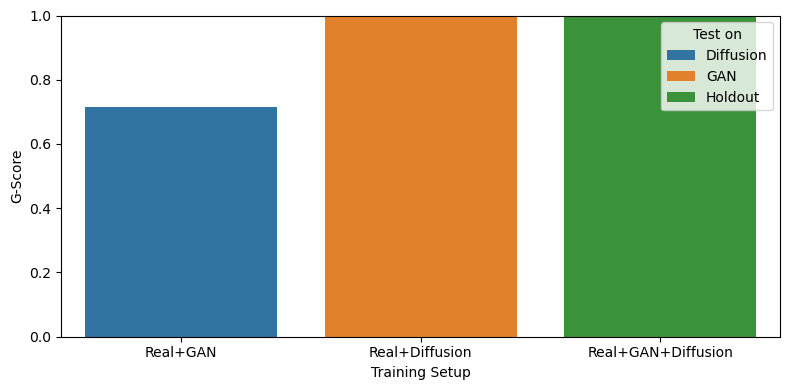

In [13]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from PIL import Image
import torch
from torchvision import models, transforms
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops

# ---------------- DEVICE & VGG SETUP ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features[:9].to(device)
vgg.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

@torch.no_grad()
def extract_vgg_features(image_path):
    try:
        img = Image.open(image_path).convert("RGB")
        x = transform(img).unsqueeze(0).to(device)
        feat_map = vgg(x).squeeze(0).cpu()
        return feat_map.mean(dim=(1, 2)).numpy()
    except:
        return None

def extract_lbp_glcm_features(image, radius=1, n_points=8):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    n_bins = n_points + 2  
    lbp_hist, _ = np.histogram(
        lbp.ravel(),
        bins=n_bins,
        range=(0, n_bins),
        density=True
    )
    glcm = graycomatrix(
        image,
        distances=[1],
        angles=[0],
        levels=256,
        symmetric=True,
        normed=True
    )
    props = ['contrast', 'homogeneity', 'energy', 'correlation']
    glcm_feats = [graycoprops(glcm, p)[0, 0] for p in props]

    return np.concatenate([lbp_hist, glcm_feats])

# ---------------- DATASET ----------------

DATASETS = {
    'bedroom': {
        'real': "../data/BEST/bedroom/real_200x200",
        'gan': "../data/BEST/bedroom/gansformer",
        'diffusion': "../data/BEST/bedroom/ddpm"
    },
    'face': {
        'real': "../data/BEST/face/real",
        'gan': "../data/BEST/face/stylegan2",
        'diffusion': "../data/BEST/face/palette"
    },
    'imagenet': {
        'real': '../data/BEST/imagenet/real_imagenet',
        'gan': '../data/BEST/imagenet/big_gan',
        'diffusion': '../data/BEST/imagenet/vq_diffusion'
    }
}

# ---------------- LOAD FEATURES ----------------

def load_texture_structure_by_class(dataset_dict):
    data = {'real': [], 'gan': [], 'diffusion': []}
    for label, root_folder in dataset_dict.items():
        print(f"[INFO] Extracting {label} features...")
        image_paths = []
        for dirpath, _, filenames in os.walk(root_folder):
            for fname in filenames:
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(dirpath, fname))
        for img_path in tqdm(image_paths, desc=f"  └─ {label}", unit="img", ncols=80):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = img.astype(np.float32) / 255.0
            feat_lbp = extract_lbp_glcm_features(img)
            feat_vgg = extract_vgg_features(img_path)
            if feat_vgg is None:
                continue
            data[label].append(np.concatenate([feat_lbp, feat_vgg]))
        print(f"  └─ Loaded {len(data[label])} features for '{label}'\n")
    return data

# ---------------- GENERALIZATION EXPERIMENT ----------------

def run_generalization_experiment(data, train_labels, test_label, title_suffix=''):
    # Split real class
    real_data = data['real']
    train_real_all, unseen_real = train_test_split(real_data, test_size=0.15, random_state=42)

    # Other class
    other_class = [lbl for lbl in train_labels if lbl != 'real'][0]
    train_other_all, _ = train_test_split(data[other_class], test_size=0.15, random_state=42)

    # Undersample to equal size
    n_train = min(len(train_real_all), len(train_other_all))
    train_real  = train_real_all[:n_train]
    train_other = train_other_all[:n_train]

    X_train_full = train_real + train_other
    y_train_full = [0]*n_train + [1]*n_train

    # Validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full,
        stratify=y_train_full, test_size=0.3, random_state=42
    )

    # Balance training set
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)

    # Build unseen test set
    _, unseen_fake = train_test_split(data[test_label], test_size=0.15, random_state=42)
    n_unseen = min(len(unseen_real), len(unseen_fake), len(y_val))
    X_test = unseen_real[:n_unseen] + unseen_fake[:n_unseen]
    y_test = [0]*n_unseen + [1]*n_unseen

    # Train classifier
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    # Predictions
    y_val_pred  = clf.predict(X_val[:2*n_unseen])
    y_test_pred = clf.predict(X_test)

    acc_seen   = accuracy_score(y_val[:2*n_unseen], y_val_pred)
    acc_unseen = accuracy_score(y_test, y_test_pred)
    g_score    = 1 - ((acc_seen - acc_unseen) / (acc_seen + 1e-8))

    # Plot confusion matrices
    def plot_cm(y_true, y_pred, title):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
        plt.title(title)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    plot_cm(y_val[:2*n_unseen], y_val_pred,  f"Confusion Matrix - Seen ({title_suffix})")
    plot_cm(y_test,           y_test_pred, f"Confusion Matrix - Unseen ({title_suffix})")

    # Per‐label unseen accuracy
    cm_u = confusion_matrix(y_test, y_test_pred)
    acc_real_unseen = cm_u[0,0]/cm_u[0].sum() if cm_u[0].sum()>0 else 0.0
    acc_fake_unseen = cm_u[1,1]/cm_u[1].sum() if cm_u[1].sum()>0 else 0.0

    print(f"Unseen Accuracy per label ({title_suffix}): "
          f"Real={acc_real_unseen:.4f}, Fake={acc_fake_unseen:.4f}")

    return (
        round(acc_seen, 4),
        round(acc_unseen, 4),
        round(g_score,    4),
        round(acc_real_unseen, 4),
        round(acc_fake_unseen, 4)
    )

# ---------------- PIPELINE RUNNER ----------------
def run_generalization_pipeline(dataset_name='imagenet'):
    data    = load_texture_structure_by_class(DATASETS[dataset_name])
    results = []

    # 1) Real + GAN → Diffusion
    s, u, g, r_acc, f_acc = run_generalization_experiment(
        data, ['real','gan'], 'diffusion', title_suffix='Real+GAN→Diffusion'
    )
    results.append(['Real+GAN', 'Diffusion', s, u, g, r_acc, f_acc])

    # 2) Real + Diffusion → GAN
    s, u, g, r_acc, f_acc = run_generalization_experiment(
        data, ['real','diffusion'], 'gan', title_suffix='Real+Diffusion→GAN'
    )
    results.append(['Real+Diffusion', 'GAN', s, u, g, r_acc, f_acc])

    # 3) Holdout with all three
    X_all = data['real'] + data['gan'] + data['diffusion']
    y_all = [0]*len(data['real']) + [1]*len(data['gan']) + [1]*len(data['diffusion'])
    X_bal, y_bal = SMOTE(random_state=42).fit_resample(X_all, y_all)

    X_temp, X_test, y_temp, y_test = train_test_split(
        X_bal, y_bal, test_size=0.15, stratify=y_bal, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
    )

    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)

    seen_acc   = accuracy_score(y_val,     clf.predict(X_val))
    unseen_acc = accuracy_score(y_test,    clf.predict(X_test))
    g_score    = 1 - ((seen_acc - unseen_acc) / (seen_acc + 1e-8))

    cm_h = confusion_matrix(y_test, clf.predict(X_test))
    real_acc = cm_h[0,0]/cm_h[0].sum()
    fake_acc = cm_h[1,1]/cm_h[1].sum()

    results.append([
        'Real+GAN+Diffusion', 'Holdout',
        round(seen_acc,4), round(unseen_acc,4), round(g_score,4),
        round(real_acc,4), round(fake_acc,4)
    ])

    df = pd.DataFrame(
        results,
        columns=[
            "Training Setup","Test on",
            "Accuracy (Seen)","Accuracy (Unseen)","G-Score",
            "Unseen Real Acc","Unseen Fake Acc"
        ]
    )
    print("\n=== Generalization Results (ImageNet dataset: Texture & Structure Data) ===")
    print(df)
    return df

# ---------------- USAGE ----------------
if __name__ == "__main__":
    df = run_generalization_pipeline(dataset_name='imagenet')
    plt.figure(figsize=(8,4))
    sns.barplot(data=df, x="Training Setup", y="G-Score", hue="Test on")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

### WE CAN'T PROVE that Real+Diffusion => GAN > Real+GAN ==> Diffusion

In [14]:
import numpy as np
from scipy import stats

# G-Score for Real+GAN -> Diffusion and Real+Diffusion -> GAN
rgd = np.array([
    0.9108, 0.6784, 0.6481, 0.7137,  # ImageNet: Color, Noise, Frequency, Texture
    0.9578, 1.0361, 1.2573, 1.0605,  # Face: Color, Noise, Frequency, Texture
    0.6120, 0.7900, 0.9950, 0.8057   # Bedroom: Color, Noise, Frequency, Texture
])

rdg = np.array([
    0.9883, 1.0492, 1.2505, 1.0045,  # ImageNet: Color, Noise, Frequency, Texture
    0.9509, 0.7575, 0.6720, 0.8058,  # Face: Color, Noise, Frequency, Texture
    0.7220, 1.0762, 1.0015, 1.0195   # Bedroom: Color, Noise, Frequency, Texture
])

# Paired t-test
t_stat, p_two_sided = stats.ttest_rel(rdg, rgd)

# One-sided p-value for alternative rdg > rgd
p_one_sided = p_two_sided / 2 if t_stat > 0 else 1 - p_two_sided / 2

mean_diff = (rdg - rgd).mean()

results = {
    "Mean Difference": mean_diff,
    "t-statistic": t_stat,
    "Two-sided p-value": p_two_sided,
    "One-sided p-value": p_one_sided
}

import pandas as pd
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Value'])
results_df

,Value
Mean Difference,0.069375
t-statistic,0.740666
Two-sided p-value,0.474410
One-sided p-value,0.237205


In [17]:
pip install ace_tools

Note: you may need to restart the kernel to use updated packages.


In [19]:
import numpy as np
import pandas as pd
from scipy.stats import friedmanchisquare, wilcoxon

# G-scores for each feature type across 3 datasets × 3 setups (R+GAN->Diff, R+Diff->GAN, Holdout)
g_scores = {
    'Color':    np.array([0.9108, 0.9883, 0.9835, 0.9509, 0.6120, 0.7220]),
    'Noise':    np.array([0.6784, 1.0492, 1.0361, 0.7575, 0.7900, 1.0762]),
    'Frequency':np.array([0.6481, 1.2505, 1.2573, 0.6720, 0.9950, 1.0015]),
    'Texture':  np.array([0.7137, 1.0045, 1.0605, 0.8058, 0.8057, 1.0195])
}

# Summary statistics
summary = pd.DataFrame({
    'Mean': [scores.mean() for scores in g_scores.values()],
    'Std Dev': [scores.std(ddof=1) for scores in g_scores.values()]
}, index=g_scores.keys())

# Friedman test for repeated measures
friedman_stat, friedman_p = friedmanchisquare(
    g_scores['Color'], g_scores['Noise'],
    g_scores['Frequency'], g_scores['Texture']
)

# Pairwise Wilcoxon tests
pairs = []
p_values = []
features = list(g_scores.keys())
for i in range(len(features)):
    for j in range(i+1, len(features)):
        f1, f2 = features[i], features[j]
        stat, p = wilcoxon(g_scores[f1], g_scores[f2])
        pairs.append(f"{f1} vs {f2}")
        p_values.append(p)

pairwise = pd.DataFrame({'Comparison': pairs, 'Wilcoxon p-value': p_values})

# Display results
results = {
    'Friedman χ²': friedman_stat,
    'Friedman p-value': friedman_p
}

results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Value'])

# Present all
print("\n=== G-score Summary and Tests ===")
print(summary.to_string(index=False))

print("\n=== Friedman Test Result ===")
print(results_df.to_string(index=False))

print("\n=== Pairwise Wilcoxon Tests ===")
print(pairwise.to_string(index=False))


=== G-score Summary and Tests ===
    Mean  Std Dev
0.861250 0.156905
0.897900 0.175109
0.970733 0.266556
0.901617 0.143819

=== Friedman Test Result ===
   Value
1.400000
0.705535

=== Pairwise Wilcoxon Tests ===
          Comparison  Wilcoxon p-value
      Color vs Noise           0.84375
  Color vs Frequency           0.43750
    Color vs Texture           0.68750
  Noise vs Frequency           0.43750
    Noise vs Texture           1.00000
Frequency vs Texture           0.43750
